In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.neural_network import MLPRegressor

from datetime import datetime as dt
from matplotlib import pyplot as plt, dates as mdates

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

new_size = plt.rcParams["figure.figsize"] = (8,8)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("DataSet.csv")


In [3]:
# check for missing values
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed_ROI,711.0,1823.177414,3396.716734,2.429,276.285500,543.286000,1755.785500,23752.000000
stringency_index_ROI,739.0,60.104384,21.170897,11.110,44.440000,55.090000,81.480000,90.740000
new_cases_smoothed_NI,739.0,372.288104,348.920281,2.000,60.903035,309.655122,500.560061,1391.109156
COVID: (Ireland),739.0,29.391069,13.712296,14.000,20.000000,26.000000,34.000000,100.000000
COVID: (Northern Ireland),739.0,36.274696,14.342275,14.000,27.000000,34.000000,43.000000,100.000000


In [4]:
# Use forward fill to replace the missing values
df['new_cases_smoothed_ROI'].fillna(method='ffill', inplace=True)

In [5]:
# re-check this missing values have been filled
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed_ROI,739.0,1832.751210,3348.781724,2.429,286.500000,551.143000,1755.785500,23752.000000
stringency_index_ROI,739.0,60.104384,21.170897,11.110,44.440000,55.090000,81.480000,90.740000
new_cases_smoothed_NI,739.0,372.288104,348.920281,2.000,60.903035,309.655122,500.560061,1391.109156
COVID: (Ireland),739.0,29.391069,13.712296,14.000,20.000000,26.000000,34.000000,100.000000
COVID: (Northern Ireland),739.0,36.274696,14.342275,14.000,27.000000,34.000000,43.000000,100.000000


In [6]:
# ensure the dates are correctly formated
df["date"] = pd.to_datetime(df["date"], format='%d/%m/%Y')

In [7]:
# set the index as date 
df.set_index("date", inplace=True)

In [8]:
# add the ROI new cases smoothed with the NI new cases smoothed
df['ROI_NI'] = df['new_cases_smoothed_ROI']+df['new_cases_smoothed_NI']

In [9]:
# check the date format is correct
df.tail()

,new_cases_smoothed_ROI,stringency_index_ROI,new_cases_smoothed_NI,COVID: (Ireland),COVID: (Northern Ireland),ROI_NI
date,,,,,,
2022-03-10,3085.143,14.81,1384.048922,17,25,4469.191922
2022-03-11,3818.000,14.81,1386.819135,17,25,5204.819135
2022-03-12,3818.000,14.81,1382.484650,17,25,5200.484650
2022-03-13,3818.000,14.81,1378.165554,17,25,5196.165554
2022-03-14,4448.857,14.81,1391.109156,17,25,5839.966156


### Split the data into different dataframe to represent each of our categories
- df_cat1 is ROI New Cases Smoothed Only
- df_cat2 is ROI New Cases Smoothed + COVID: Ireland
- df_cat3 is ROI New Cases Smoothed + COVID: Ireland + Stringency Index
- df_cat4 is NI New Cases Smoothed Only
- df_cat5 is NI New Cases Smoothed + COVID: Norther Ireland
- df_cat6 is ROI + NI New Cases Smoothed
- df_cat7 is ROI + NI New Cases Smoothed + COVID: Ireland + COVID: Northern Ireland

In [10]:
# Create new dataframes each with features for one of the categories we are going to train the model with
df_cat1 = df.copy(deep=True).loc[:,['new_cases_smoothed_ROI']]
df_cat2 = df.copy(deep=True).loc[:,['new_cases_smoothed_ROI','COVID: (Ireland)']]
df_cat3 = df.copy(deep=True).loc[:,['new_cases_smoothed_ROI','stringency_index_ROI','COVID: (Ireland)',]]
df_cat4 = df.copy(deep=True).loc[:,['new_cases_smoothed_NI']]
df_cat5 = df.copy(deep=True).loc[:,['new_cases_smoothed_NI','COVID: (Northern Ireland)']]
df_cat6 = df.copy(deep=True).loc[:,['ROI_NI']]
df_cat7 = df.copy(deep=True).loc[:,['ROI_NI','COVID: (Ireland)','COVID: (Northern Ireland)']]

#### Change 'df_model' to which ever category you wish to run
- You will need to comment out any feature TimeShifts that are not being used in your choosen category
- Be careful when modifify which y_train, y_test and y_val values that are dropped, there is a big risk of copy/ paste errors
- Remember to change the first shift to what ever time shift your are running for each of the features being ran .e.g. to shift 7 - 14 days on new cases smooth: df_model.loc[:,'yesterday'] = df_model.loc[:,'new_cases_smoothed_ROI'].shift(7)
- don't forget to TimeShift all of the features!

In [11]:
# change the model to whatever category you choose to run
df_model = df_cat3.copy(deep=True)

In [12]:
# This is the TimeShift for New Cases Smoothed in the Republic of Ireland
# Comment/ Uncomment as needed
df_model.loc[:,'yesterday'] = df_model.loc[:,'new_cases_smoothed_ROI'].shift(7)
df_model.loc[:,'yesterday_diff'] = df_model.loc[:,'yesterday'].diff()
df_model.loc[:,'yesterday2'] = df_model.loc[:,'yesterday'].shift()
df_model.loc[:,'yesterday_diff2'] = df_model.loc[:,'yesterday2'].diff()
df_model.loc[:,'yesterday3'] = df_model.loc[:,'yesterday2'].shift()
df_model.loc[:,'yesterday_diff3'] = df_model.loc[:,'yesterday3'].diff()
df_model.loc[:,'yesterday4'] = df_model.loc[:,'yesterday3'].shift()
df_model.loc[:,'yesterday_diff4'] = df_model.loc[:,'yesterday4'].diff()
df_model.loc[:,'yesterday5'] = df_model.loc[:,'yesterday4'].shift()
df_model.loc[:,'yesterday_diff5'] = df_model.loc[:,'yesterday5'].diff()
df_model.loc[:,'yesterday6'] = df_model.loc[:,'yesterday5'].shift()
df_model.loc[:,'yesterday_diff6'] = df_model.loc[:,'yesterday6'].diff()
df_model.loc[:,'yesterday7'] = df_model.loc[:,'yesterday6'].shift()
df_model.loc[:,'yesterday_diff7'] = df_model.loc[:,'yesterday7'].diff()

In [13]:
# This is the TimeShift for New Cases Smoothed in the Northern Ireland
# Comment/ Uncomment as needed
# df_model.loc[:,'yesterdayNI'] = df_model.loc[:,'new_cases_smoothed_NI'].shift(7)
# df_model.loc[:,'yesterdayNI_diff'] = df_model.loc[:,'yesterdayNI'].diff()
# df_model.loc[:,'yesterdayNI2'] = df_model.loc[:,'yesterdayNI'].shift()
# df_model.loc[:,'yesterdayNI_diff2'] = df_model.loc[:,'yesterdayNI2'].diff()
# df_model.loc[:,'yesterdayNI3'] = df_model.loc[:,'yesterdayNI2'].shift()
# df_model.loc[:,'yesterdayNI_diff3'] = df_model.loc[:,'yesterdayNI3'].diff()
# df_model.loc[:,'yesterdayNI4'] = df_model.loc[:,'yesterdayNI3'].shift()
# df_model.loc[:,'yesterdayNI_diff4'] = df_model.loc[:,'yesterdayNI4'].diff()
# df_model.loc[:,'yesterdayNI5'] = df_model.loc[:,'yesterdayNI4'].shift()
# df_model.loc[:,'yesterdayNI_diff5'] = df_model.loc[:,'yesterdayNI5'].diff()
# df_model.loc[:,'yesterdayNI6'] = df_model.loc[:,'yesterdayNI5'].shift()
# df_model.loc[:,'yesterdayNI_diff6'] = df_model.loc[:,'yesterdayNI6'].diff()
# df_model.loc[:,'yesterdayNI7'] = df_model.loc[:,'yesterdayNI6'].shift()
# df_model.loc[:,'yesterdayNI_diff7'] = df_model.loc[:,'yesterdayNI7'].diff()

In [14]:
# This is the TimeShift for stringency index. 
# Comment/ Uncomment as needed
df_model.loc[:,'si'] = df_model.loc[:,'stringency_index_ROI'].shift(7)
df_model.loc[:,'si_diff'] = df_model.loc[:,'si'].diff()
df_model.loc[:,'si2'] = df_model.loc[:,'si'].shift()
df_model.loc[:,'si_diff2'] = df_model.loc[:,'si2'].diff()
df_model.loc[:,'si3'] = df_model.loc[:,'si2'].shift()
df_model.loc[:,'si_diff3'] = df_model.loc[:,'si3'].diff()
df_model.loc[:,'si4'] = df_model.loc[:,'si3'].shift()
df_model.loc[:,'si_diff4'] = df_model.loc[:,'si4'].diff()
df_model.loc[:,'si5'] = df_model.loc[:,'si4'].shift()
df_model.loc[:,'si_diff5'] = df_model.loc[:,'si5'].diff()
df_model.loc[:,'si6'] = df_model.loc[:,'si5'].shift()
df_model.loc[:,'si_diff6'] = df_model.loc[:,'si6'].diff()
df_model.loc[:,'si7'] = df_model.loc[:,'si6'].shift()
df_model.loc[:,'si_diff7'] = df_model.loc[:,'si7'].diff()

In [15]:
# This is the TimeShift for Google Trends COVID-19 searches in Ireland
# Comment/ Uncomment as needed
df_model.loc[:,'covid_ROI'] = df_model.loc[:,'COVID: (Ireland)'].shift(7)
df_model.loc[:,'covid_ROI_diff'] = df_model.loc[:,'covid_ROI'].diff()
df_model.loc[:,'covid_ROI2'] = df_model.loc[:,'covid_ROI'].shift()
df_model.loc[:,'covid_ROI_diff2'] = df_model.loc[:,'covid_ROI2'].diff()
df_model.loc[:,'covid_ROI3'] = df_model.loc[:,'covid_ROI2'].shift()
df_model.loc[:,'covid_ROI_diff3'] = df_model.loc[:,'covid_ROI3'].diff()
df_model.loc[:,'covid_ROI4'] = df_model.loc[:,'covid_ROI3'].shift()
df_model.loc[:,'covid_ROI_diff4'] = df_model.loc[:,'covid_ROI4'].diff()
df_model.loc[:,'covid_ROI5'] = df_model.loc[:,'covid_ROI4'].shift()
df_model.loc[:,'covid_ROI_diff5'] = df_model.loc[:,'covid_ROI5'].diff()
df_model.loc[:,'covid_ROI6'] = df_model.loc[:,'covid_ROI5'].shift()
df_model.loc[:,'covid_ROI_diff6'] = df_model.loc[:,'covid_ROI6'].diff()
df_model.loc[:,'covid_ROI7'] = df_model.loc[:,'covid_ROI6'].shift()
df_model.loc[:,'covid_ROI_diff7'] = df_model.loc[:,'covid_ROI7'].diff()

In [16]:
# This is the TimeShift for Google Trends COVID-19 searches in Northern Ireland
# Comment/ Uncomment as needed
# df_model.loc[:,'covid_NI'] = df_model.loc[:,'COVID: (Northern Ireland)'].shift()
# df_model.loc[:,'covid_NI_diff'] = df_model.loc[:,'covid_NI'].diff()
# df_model.loc[:,'covid_NI2'] = df_model.loc[:,'covid_NI'].shift()
# df_model.loc[:,'covid_NI_diff2'] = df_model.loc[:,'covid_NI2'].diff()
# df_model.loc[:,'covid_NI3'] = df_model.loc[:,'covid_NI2'].shift()
# df_model.loc[:,'covid_NI_diff3'] = df_model.loc[:,'covid_NI3'].diff()
# df_model.loc[:,'covid_NI4'] = df_model.loc[:,'covid_NI3'].shift()
# df_model.loc[:,'covid_NI_diff4'] = df_model.loc[:,'covid_NI4'].diff()
# df_model.loc[:,'covid_NI5'] = df_model.loc[:,'covid_NI4'].shift()
# df_model.loc[:,'covid_NI_diff5'] = df_model.loc[:,'covid_NI5'].diff()
# df_model.loc[:,'covid_NI6'] = df_model.loc[:,'covid_NI5'].shift()
# df_model.loc[:,'covid_NI_diff6'] = df_model.loc[:,'covid_NI6'].diff()
# df_model.loc[:,'covid_NI7'] = df_model.loc[:,'covid_NI6'].shift()
# df_model.loc[:,'covid_NI_diff7'] = df_model.loc[:,'covid_NI7'].diff()

In [17]:
# This is the TimeShift for the Sum of Smoothed Northern Ireland and Replubic of Ireland daily cases
# Comment/ Uncomment as needed
# df_model.loc[:,'ROI_NI'] = df_model.loc[:,'ROI_NI'].shift()
# df_model.loc[:,'ROI_NI_diff'] = df_model.loc[:,'ROI_NI'].diff()
# df_model.loc[:,'ROI_NI2'] = df_model.loc[:,'ROI_NI'].shift()
# df_model.loc[:,'ROI_NI_diff2'] = df_model.loc[:,'ROI_NI2'].diff()
# df_model.loc[:,'ROI_NI3'] = df_model.loc[:,'ROI_NI2'].shift()
# df_model.loc[:,'ROI_NI_diff3'] = df_model.loc[:,'ROI_NI3'].diff()
# df_model.loc[:,'ROI_NI4'] = df_model.loc[:,'ROI_NI3'].shift()
# df_model.loc[:,'ROI_NI_diff4'] = df_model.loc[:,'ROI_NI4'].diff()
# df_model.loc[:,'ROI_NI5'] = df_model.loc[:,'ROI_NI4'].shift()
# df_model.loc[:,'ROI_NI_diff5'] = df_model.loc[:,'ROI_NI5'].diff()
# df_model.loc[:,'ROI_NI6'] = df_model.loc[:,'ROI_NI5'].shift()
# df_model.loc[:,'ROI_NI_diff6'] = df_model.loc[:,'ROI_NI6'].diff()
# df_model.loc[:,'ROI_NI7'] = df_model.loc[:,'ROI_NI6'].shift()
# df_model.loc[:,'ROI_NI_diff7'] = df_model.loc[:,'ROI_NI7'].diff()

In [18]:
# Check the model dataframe has all the features that you need. 
df_model.columns

Index(['new_cases_smoothed_ROI', 'stringency_index_ROI', 'COVID: (Ireland)',
       'yesterday', 'yesterday_diff', 'yesterday2', 'yesterday_diff2',
       'yesterday3', 'yesterday_diff3', 'yesterday4', 'yesterday_diff4',
       'yesterday5', 'yesterday_diff5', 'yesterday6', 'yesterday_diff6',
       'yesterday7', 'yesterday_diff7', 'si', 'si_diff', 'si2', 'si_diff2',
       'si3', 'si_diff3', 'si4', 'si_diff4', 'si5', 'si_diff5', 'si6',
       'si_diff6', 'si7', 'si_diff7', 'covid_ROI', 'covid_ROI_diff',
       'covid_ROI2', 'covid_ROI_diff2', 'covid_ROI3', 'covid_ROI_diff3',
       'covid_ROI4', 'covid_ROI_diff4', 'covid_ROI5', 'covid_ROI_diff5',
       'covid_ROI6', 'covid_ROI_diff6', 'covid_ROI7', 'covid_ROI_diff7'],
      dtype='object')

In [19]:
# Backfill and Forward Fill missing values that resulted from the TimeShift
df_model = df_model.fillna(method='bfill').fillna(method='ffill')

In [20]:
# Check that all missing values have been filled
df_model.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
new_cases_smoothed_ROI,739.0,1832.751210,3348.781724,2.429,286.5000,551.143,1755.7855,23752.000
stringency_index_ROI,739.0,60.104384,21.170897,11.110,44.4400,55.090,81.4800,90.740
COVID: (Ireland),739.0,29.391069,13.712296,14.000,20.0000,26.000,34.0000,100.000
yesterday,739.0,1798.419483,3348.492464,2.429,276.2855,543.286,1708.4285,23752.000
yesterday_diff,739.0,4.280505,429.551908,-5347.429,-13.8570,0.000,18.6430,3903.143
yesterday2,739.0,1794.137441,3348.763276,2.429,275.2140,543.286,1705.3570,23752.000
yesterday_diff2,739.0,4.419303,429.533860,-5347.429,-13.6430,0.000,18.6430,3903.143
yesterday3,739.0,1789.716409,3348.969215,2.429,273.5715,536.857,1701.7855,23752.000
yesterday_diff3,739.0,4.419111,429.533862,-5347.429,-13.6430,0.000,18.6430,3903.143
yesterday4,739.0,1785.295376,3349.169297,2.429,271.6430,535.571,1701.0000,23752.000


In [21]:
# get the number of rows and assign to n: for the train best split
n = len(df_model)

In [22]:
# Re-check the model dataframe has all the features that you need. You can copy the features to drop from here
df_model.columns

Index(['new_cases_smoothed_ROI', 'stringency_index_ROI', 'COVID: (Ireland)',
       'yesterday', 'yesterday_diff', 'yesterday2', 'yesterday_diff2',
       'yesterday3', 'yesterday_diff3', 'yesterday4', 'yesterday_diff4',
       'yesterday5', 'yesterday_diff5', 'yesterday6', 'yesterday_diff6',
       'yesterday7', 'yesterday_diff7', 'si', 'si_diff', 'si2', 'si_diff2',
       'si3', 'si_diff3', 'si4', 'si_diff4', 'si5', 'si_diff5', 'si6',
       'si_diff6', 'si7', 'si_diff7', 'covid_ROI', 'covid_ROI_diff',
       'covid_ROI2', 'covid_ROI_diff2', 'covid_ROI3', 'covid_ROI_diff3',
       'covid_ROI4', 'covid_ROI_diff4', 'covid_ROI5', 'covid_ROI_diff5',
       'covid_ROI6', 'covid_ROI_diff6', 'covid_ROI7', 'covid_ROI_diff7'],
      dtype='object')

In [23]:
X_train = df_model.iloc[0:int(n*0.7)].drop(['new_cases_smoothed_ROI',
                                            'stringency_index_ROI', 'COVID: (Ireland)'], axis=1)

# Extreme copy/ paste warning. Make sure all unneeded columns are dropped
y_train = df_model.iloc[0:int(n*0.7)].drop(columns=['stringency_index_ROI', 'COVID: (Ireland)',
       'yesterday', 'yesterday_diff', 'yesterday2', 'yesterday_diff2',
       'yesterday3', 'yesterday_diff3', 'yesterday4', 'yesterday_diff4',
       'yesterday5', 'yesterday_diff5', 'yesterday6', 'yesterday_diff6',
       'yesterday7', 'yesterday_diff7', 'si', 'si_diff', 'si2', 'si_diff2',
       'si3', 'si_diff3', 'si4', 'si_diff4', 'si5', 'si_diff5', 'si6',
       'si_diff6', 'si7', 'si_diff7', 'covid_ROI', 'covid_ROI_diff',
       'covid_ROI2', 'covid_ROI_diff2', 'covid_ROI3', 'covid_ROI_diff3',
       'covid_ROI4', 'covid_ROI_diff4', 'covid_ROI5', 'covid_ROI_diff5',
       'covid_ROI6', 'covid_ROI_diff6', 'covid_ROI7', 'covid_ROI_diff7'], axis=1)

In [24]:
X_test = df_model.iloc[int(n*0.7):int(n*0.9)].drop(['new_cases_smoothed_ROI',
                                            'stringency_index_ROI', 'COVID: (Ireland)'],axis=1)

# Extreme copy/ paste warning. Make sure all unneeded columns are dropped
y_test = df_model.iloc[int(n*0.7):int(n*0.9)].drop(columns=['stringency_index_ROI', 'COVID: (Ireland)',
       'yesterday', 'yesterday_diff', 'yesterday2', 'yesterday_diff2',
       'yesterday3', 'yesterday_diff3', 'yesterday4', 'yesterday_diff4',
       'yesterday5', 'yesterday_diff5', 'yesterday6', 'yesterday_diff6',
       'yesterday7', 'yesterday_diff7', 'si', 'si_diff', 'si2', 'si_diff2',
       'si3', 'si_diff3', 'si4', 'si_diff4', 'si5', 'si_diff5', 'si6',
       'si_diff6', 'si7', 'si_diff7', 'covid_ROI', 'covid_ROI_diff',
       'covid_ROI2', 'covid_ROI_diff2', 'covid_ROI3', 'covid_ROI_diff3',
       'covid_ROI4', 'covid_ROI_diff4', 'covid_ROI5', 'covid_ROI_diff5',
       'covid_ROI6', 'covid_ROI_diff6', 'covid_ROI7', 'covid_ROI_diff7'], axis=1)

In [25]:
X_val = df_model.iloc[int(n*0.9):].drop(['new_cases_smoothed_ROI',
                                            'stringency_index_ROI', 'COVID: (Ireland)'], axis=1)

# Extreme copy/ paste warning. Make sure all unneeded columns are dropped
y_val = df_model.iloc[int(n*0.9):].drop(columns=['stringency_index_ROI', 'COVID: (Ireland)',
       'yesterday', 'yesterday_diff', 'yesterday2', 'yesterday_diff2',
       'yesterday3', 'yesterday_diff3', 'yesterday4', 'yesterday_diff4',
       'yesterday5', 'yesterday_diff5', 'yesterday6', 'yesterday_diff6',
       'yesterday7', 'yesterday_diff7', 'si', 'si_diff', 'si2', 'si_diff2',
       'si3', 'si_diff3', 'si4', 'si_diff4', 'si5', 'si_diff5', 'si6',
       'si_diff6', 'si7', 'si_diff7', 'covid_ROI', 'covid_ROI_diff',
       'covid_ROI2', 'covid_ROI_diff2', 'covid_ROI3', 'covid_ROI_diff3',
       'covid_ROI4', 'covid_ROI_diff4', 'covid_ROI5', 'covid_ROI_diff5',
       'covid_ROI6', 'covid_ROI_diff6', 'covid_ROI7', 'covid_ROI_diff7'], axis=1)

### Verify all the training, test and validation columns are as expected

In [26]:
X_train.columns

Index(['yesterday', 'yesterday_diff', 'yesterday2', 'yesterday_diff2',
       'yesterday3', 'yesterday_diff3', 'yesterday4', 'yesterday_diff4',
       'yesterday5', 'yesterday_diff5', 'yesterday6', 'yesterday_diff6',
       'yesterday7', 'yesterday_diff7', 'si', 'si_diff', 'si2', 'si_diff2',
       'si3', 'si_diff3', 'si4', 'si_diff4', 'si5', 'si_diff5', 'si6',
       'si_diff6', 'si7', 'si_diff7', 'covid_ROI', 'covid_ROI_diff',
       'covid_ROI2', 'covid_ROI_diff2', 'covid_ROI3', 'covid_ROI_diff3',
       'covid_ROI4', 'covid_ROI_diff4', 'covid_ROI5', 'covid_ROI_diff5',
       'covid_ROI6', 'covid_ROI_diff6', 'covid_ROI7', 'covid_ROI_diff7'],
      dtype='object')

In [27]:
y_train.columns

Index(['new_cases_smoothed_ROI'], dtype='object')

In [28]:
X_test.columns

Index(['yesterday', 'yesterday_diff', 'yesterday2', 'yesterday_diff2',
       'yesterday3', 'yesterday_diff3', 'yesterday4', 'yesterday_diff4',
       'yesterday5', 'yesterday_diff5', 'yesterday6', 'yesterday_diff6',
       'yesterday7', 'yesterday_diff7', 'si', 'si_diff', 'si2', 'si_diff2',
       'si3', 'si_diff3', 'si4', 'si_diff4', 'si5', 'si_diff5', 'si6',
       'si_diff6', 'si7', 'si_diff7', 'covid_ROI', 'covid_ROI_diff',
       'covid_ROI2', 'covid_ROI_diff2', 'covid_ROI3', 'covid_ROI_diff3',
       'covid_ROI4', 'covid_ROI_diff4', 'covid_ROI5', 'covid_ROI_diff5',
       'covid_ROI6', 'covid_ROI_diff6', 'covid_ROI7', 'covid_ROI_diff7'],
      dtype='object')

In [29]:
y_test.columns

Index(['new_cases_smoothed_ROI'], dtype='object')

In [30]:
X_val.columns

Index(['yesterday', 'yesterday_diff', 'yesterday2', 'yesterday_diff2',
       'yesterday3', 'yesterday_diff3', 'yesterday4', 'yesterday_diff4',
       'yesterday5', 'yesterday_diff5', 'yesterday6', 'yesterday_diff6',
       'yesterday7', 'yesterday_diff7', 'si', 'si_diff', 'si2', 'si_diff2',
       'si3', 'si_diff3', 'si4', 'si_diff4', 'si5', 'si_diff5', 'si6',
       'si_diff6', 'si7', 'si_diff7', 'covid_ROI', 'covid_ROI_diff',
       'covid_ROI2', 'covid_ROI_diff2', 'covid_ROI3', 'covid_ROI_diff3',
       'covid_ROI4', 'covid_ROI_diff4', 'covid_ROI5', 'covid_ROI_diff5',
       'covid_ROI6', 'covid_ROI_diff6', 'covid_ROI7', 'covid_ROI_diff7'],
      dtype='object')

In [31]:
y_val.columns

Index(['new_cases_smoothed_ROI'], dtype='object')

### Load the model and Gridsearch parameters

In [32]:
model = MLPRegressor()

param_search = {
    #"hidden_layer_sizes": [(150,)],
    "hidden_layer_sizes": [(1,),(50,),(100,),(150,),(200,),(250,),(300,),(350,)],
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [0.00005,0.0005, 0.005],
    "learning_rate": ['constant', 'invscaling', 'adaptive']
}

### Run the model

In [33]:
tsvc = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tsvc, param_grid=param_search, scoring='r2')
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

### Print the best model

In [34]:
print(best_model)

MLPRegressor(alpha=0.005, hidden_layer_sizes=(1,))


In [35]:
test_pred = best_model.predict(X_test)
print("Accuracy:", r2_score(y_test, test_pred))

Accuracy: 0.45520121904617017


In [36]:
y_test['predictions'] = test_pred.tolist()

In [37]:
y_test.reset_index(inplace=True)

In [38]:
y_test

,date,new_cases_smoothed_ROI,predictions
0,2021-08-05,1281.571,1085.486691
1,2021-08-06,1321.571,1122.569217
2,2021-08-07,1378.857,1131.097677
3,2021-08-08,1484.429,1098.996051
4,2021-08-09,1492.857,1090.506171
...,...,...,...
143,2021-12-26,8446.571,4161.452915
144,2021-12-27,8724.714,4058.390987
145,2021-12-28,9258.571,3793.334495
146,2021-12-29,10704.429,4294.855193


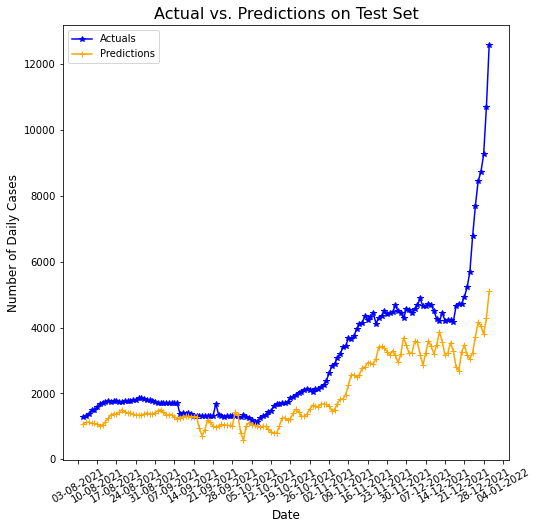

In [39]:
x = y_test['date']
ax = plt.gca()

formatter = mdates.DateFormatter("%d-%m-%Y")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.WeekdayLocator()
ax.xaxis.set_major_locator(locator)
y1 = y_test['new_cases_smoothed_ROI']
plt.plot(x, y1,'-', color='blue', marker='*')
y2 = y_test['predictions']
plt.plot(x, y2,'-', color='orange', marker='+')
plt.title("Actual vs. Predictions on Test Set", fontsize=16)
plt.legend(['Actuals','Predictions'])
plt.xticks(rotation=30)
plt.ylabel("Number of Daily Cases", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.show()

In [40]:
val_pred = best_model.predict(X_val)

In [41]:
print("Accuracy:", r2_score(y_val, val_pred))

Accuracy: 0.551793951125799


In [42]:
y_val['predictions'] = val_pred.tolist()

In [43]:
y_val.reset_index(inplace=True)

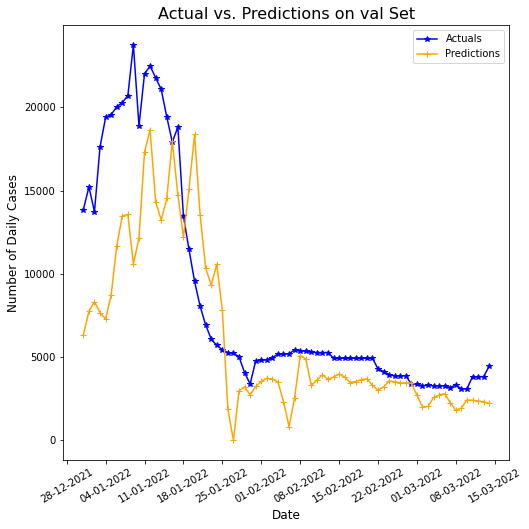

In [44]:
x = y_val['date']
ax = plt.gca()

formatter = mdates.DateFormatter("%d-%m-%Y")
ax.xaxis.set_major_formatter(formatter)
locator = mdates.WeekdayLocator()
ax.xaxis.set_major_locator(locator)
y1 = y_val['new_cases_smoothed_ROI']
plt.plot(x, y1,'-', color='blue', marker='*')
y2 = y_val['predictions']
plt.plot(x, y2,'-', color='orange', marker='+')
plt.title("Actual vs. Predictions on val Set", fontsize=16)
plt.legend(['Actuals','Predictions'])
plt.xticks(rotation=30)
plt.ylabel("Number of Daily Cases", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.savefig("cat3 Simon.jpeg")
plt.show()